In [1]:
## IMPORT LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pytz # timezones

def ingest_data(filename):
    '''Read data from a CSV file and construct a pandas DataFrame
    Inputs:
        filename as string
    Outputs:
        df as DataFrame
    '''
    # read csv file
    df = pd.read_csv(filename)

    # 'Data' column is unused. All elements contain the same value.
    # 'Time' is redundant and superseded by UNIXTime.
    df.drop(['Data','Time'],axis=1,inplace=True)

    # interpret columns as appropriate data types to ensure compatibility
    df['UNIXTime']      = pd.to_datetime(df['UNIXTime'],unit='s')
    df['Radiation']     = df['Radiation'].astype(float)
    df['Temperature']   = df['Temperature'].astype(float) # or int
    df['Pressure']      = df['Pressure'].astype(float)
    df['Humidity']      = df['Humidity'].astype(int) # or int
    df['WindDirection(Degrees)'] = df['WindDirection(Degrees)'].astype(float)
    df['Speed']         = df['Speed'].astype(float)
    df['TimeSunRise']   = pd.to_datetime(df['TimeSunRise'],format='%H:%M:%S')
    df['TimeSunSet']    = pd.to_datetime(df['TimeSunSet'],format='%H:%M:%S')
    df.rename(columns={'WindDirection(Degrees)': 'WindDirection', 'Speed': 'WindSpeed'}, inplace=True)

    # compute length of each day
    df['DayLength'] = (df['TimeSunSet']-df['TimeSunRise'])/np.timedelta64(1, 's')

    # we don't need sunrise or sunset times anymore, so drop them
    df.drop(['TimeSunRise','TimeSunSet'],axis=1,inplace=True)

    # index by UNIX time
    df.sort_values('UNIXTime', inplace=True) # sort by UNIXTime
    df.set_index('UNIXTime',inplace=True) # index by UNIXTime

    # Localize the index (using tz_localize) to UTC (to make the Timestamps timezone-aware) and then convert to Eastern (using tz_convert)
    hawaii=pytz.timezone('Pacific/Honolulu')
    df.index=df.index.tz_localize(pytz.utc).tz_convert(hawaii)

    # assign unit labels to data keys
    units={'Radiation':'W/m^2','Temperature':'F','Pressure':'in Hg','Humidity':'\%','DayLength':'sec'}
    return df, units

In [2]:
df, units = ingest_data('input/SolarPrediction.csv')
print(df.head())

                           Radiation  Temperature  Pressure  Humidity  \
UNIXTime                                                                
2016-09-01 00:00:08-10:00       2.58         51.0     30.43       103   
2016-09-01 00:05:10-10:00       2.83         51.0     30.43       103   
2016-09-01 00:20:06-10:00       2.16         51.0     30.43       103   
2016-09-01 00:25:05-10:00       2.21         51.0     30.43       103   
2016-09-01 00:30:09-10:00       2.25         51.0     30.43       103   

                           WindDirection  WindSpeed  DayLength  
UNIXTime                                                        
2016-09-01 00:00:08-10:00          77.27      11.25    45060.0  
2016-09-01 00:05:10-10:00         153.44       9.00    45060.0  
2016-09-01 00:20:06-10:00         142.04       7.87    45060.0  
2016-09-01 00:25:05-10:00         144.12      18.00    45060.0  
2016-09-01 00:30:09-10:00          67.42      11.25    45060.0  


In [3]:

import numpy as np # linear algebra
from scipy import stats # statistics
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting tools
import seaborn as sns # advanced plotting tools
sns.set(style="white")

%matplotlib inline 

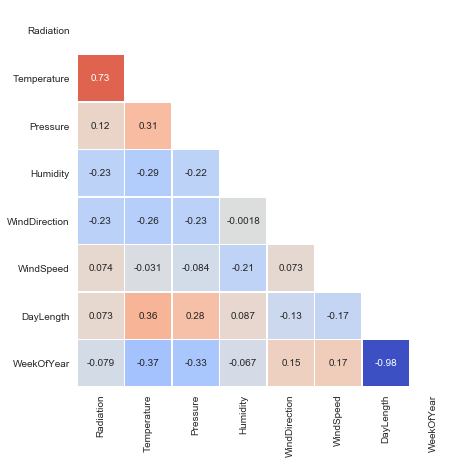

In [4]:
def corrPairs(df):
    '''Pairwise correlation matrix'''
    corr = df.corr() # Compute the correlation matrix
    mask = np.zeros_like(corr, dtype=np.bool) # make mask
    mask[np.triu_indices_from(mask)] = True # mask upper triangle
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5, annot=True, cbar=False)

df['WeekOfYear'] = df.index.week # add week to view correlation
plt.figure(figsize=(7,7))
corrPairs(df)

In [4]:
def color_y_axis(ax, color):
    '''Color y axis on two-axis plots'''
    for t in ax.get_yticklabels():
        t.set_color(color)
    ax.yaxis.label.set_color(color)
    return None

def plotVs(df,timescale,feature1,feature2,ax1,units):
    '''Plot feature vs radiation'''
    ax2=ax1.twinx()
    df_grouped= df.groupby(timescale)

    df_feature1 = df_grouped[feature1].mean()
    df_feature1_errorpos =  df_feature1+df_grouped[feature1].std()/2
    df_feature1_errorneg =  df_feature1-df_grouped[feature1].std()/2
    ax1.plot(df_feature1)
    ax1.fill_between(df_feature1.index, df_feature1_errorpos.values, df_feature1_errorneg.values, alpha=0.3, antialiased=True)
    ax1.set_ylabel(feature1+' '+units[feature1])
    color_y_axis(ax1, 'b')

    if feature2 == 'Radiation':
        rad = df_grouped['Radiation'].mean()
        ax2.plot(rad,'r')
        ax2.fill_between(df_feature1.index, 0, rad, alpha=0.3, antialiased=True, color='red')
        ax2.set_ylabel('Radiation'+' '+units['Radiation'])
        color_y_axis(ax2, 'r')
    else:
        df_feature2 = df_grouped[feature2].mean()
        df_feature2_errorpos =  df_feature2+df_grouped[feature2].std()/2
        df_feature2_errorneg =  df_feature2-df_grouped[feature2].std()/2
        ax1.plot(df_feature2)
        ax1.fill_between(df_feature2.index, df_feature2_errorpos.values, df_feature2_errorneg.values, alpha=0.3, antialiased=True)
        ax1.set_ylabel(feature2+' '+units[feature2])
        color_y_axis(ax1, 'g')
    return ax1, ax2

def HourlyWeeklyVs(df,feature1,feature2,units):
    '''Plot a feature vs radiation for time of day and week of year'''
    plt.figure(figsize=(18, 6))
    ax=plt.subplot(121) # hourly
    ax1,ax2 = plotVs(df,df.index.hour,feature1,feature2,ax,units)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    plt.xlabel('Hour of Day (Local Time)')
    plt.title('Mean Hourly {0} vs. Mean Hourly {1}'.format(feature1,feature2))

    ax=plt.subplot(122) # weekly
    ax1, ax2 = plotVs(df,pd.Grouper(freq='W'),feature1,feature2,ax,units)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    plt.xlabel('Week of Year')
    plt.title('Mean Weekly {0} vs. Mean Weekly {1}'.format(feature1,feature2))
    return


In [5]:
df.drop(['WindDirection','WindSpeed'], axis=1, inplace=True) # drop irrelevant features

In [6]:
df['TimeOfDay'] = df.index.hour # add time of day to correlation

In [7]:
# IMPORT ML CLASSIFIERS
from sklearn.linear_model import LinearRegression # Linear regression
from sklearn.ensemble import RandomForestRegressor # random forest regression
from sklearn.neural_network import MLPRegressor # neural network regression
from sklearn.svm import SVR # support vector regression

In [9]:
x = df.drop('Radiation',axis=1)
y = df['Radiation']

In [10]:
from sklearn import preprocessing # ML tools
from sklearn.model_selection import train_test_split # split data

from bokeh.plotting import figure, show, output_notebook

def plot_test(clf,X_test,y_test):
    y_predicted = clf.predict(X_test)

    p = figure(tools='pan,box_zoom,reset',x_range=[0, 100], title='Model validation',y_axis_label='radiation')
    p.grid.minor_grid_line_color = '#eeeeee'

    p.line(range(len(y_test)),y_test,legend='actual',line_color='blue')
    p.line(range(len(y_test)),y_predicted,legend='prediction',line_color='red')
    output_notebook()
    show(p)
    return

def plot_real(clf,x,y_actual,index):
    ''' Plot predictions for actual measurements.
    inputs:
        clf         as classifier   the trained algorithm
        x           as array        timeseries of measurement inputs
        y_actual    as array        corresponding timeseries of actual results
    '''
    y_predicted = clf.predict(x)

    p = figure(toolbar_location='right', title='Predicted vs Actual',y_axis_label='radiation',x_axis_type="datetime")
    p.grid.minor_grid_line_color = '#eeeeee'

    p.line(index,y_actual,legend='actual',line_color='blue')
    p.line(index,y_predicted,legend='prediction',line_color='red')
    output_notebook()
    show(p)
    return

def train_model(X,y,clf,debug=False):
    ''' Train algorithm.
    inputs:
        X       as array        features
        y       as array        label(s)
        clf     as scikit-learn classifier (untrained)
    returns:
        clf     as trained classifier
        accuracy  as float
    '''
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = clf.fit(X_train,y_train)
    accuracy = clf.score(X_test,y_test)
    return clf, model, accuracy, X_test, y_test

def go(x,y,algorithm,debug=True):
    ''' Easy model train and test. '''
    clf, model, accuracy, X_test, y_test=train_model(x,y,algorithm,debug=True)
    print('Accuracy: %s percent'%str(accuracy*100))

    if debug:
        plot_test(clf,X_test,y_test)
        plot_real(clf,x,y,df.index.values)
    return

ModuleNotFoundError: No module named 'bokeh'

In [12]:
go(x,y,LinearRegression())

Accuracy: 61.19089502541093 percent


Loading BokehJS ...

Loading BokehJS ...

In [13]:
go(x,y,RandomForestRegressor())

Accuracy: 93.30187276474064 percent


Loading BokehJS ...

Loading BokehJS ...

In [14]:
go(x,y,MLPRegressor())

Accuracy: 54.59198822145432 percent


Loading BokehJS ...

Loading BokehJS ...

In [14]:
# default algorithm for reference
print('Default random forest regressor:')
go(x,y,RandomForestRegressor(),debug=False)

# tuning round 1
print('Tuned regressor:')
go(x,y,RandomForestRegressor(n_estimators=100, n_jobs=-1),debug=False)

Default random forest regressor:
Accuracy: 93.16408008642252 percent
Tuned regressor:
Accuracy: 92.84931947820147 percent


In [15]:
def optimize_randomforest(x,y,try_n=10,try_f='auto',try_s=1):
    ''' Find best combo of tunable params for random forest regressor. '''
    best_score = float('-inf') # initialize score
    for n in try_n:
        for f in try_f:
            for s in try_s:
                clf = RandomForestRegressor(oob_score=True,n_estimators=n,max_features=f,min_samples_leaf=s,n_jobs=-1)
                clf.fit(x,y)
                if clf.oob_score_ > best_score:
                    best_score, best_clf, best_n, best_f, best_s = clf.oob_score_, clf, n, f, s
    return clf, best_n, best_f, best_s

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
n=[100,200,300,500]
f=[2,4,6]
s=[1,2,4,8,16]
clf, n, f, s = optimize_randomforest(x_train,y_train,try_n=n,try_f=f,try_s=s)
print('n_estimators: '+str(n))
print('max_features: '+str(f))
print('min_samples_leaf: '+str(s))
go(x,y,RandomForestRegressor(n_estimators=n,max_features=f,min_samples_leaf=s,n_jobs=-1))

n_estimators: 500
max_features: 2
min_samples_leaf: 2
Accuracy: 93.61464042044085 percent


Loading BokehJS ...

Loading BokehJS ...